# Set Environment

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2
import random
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Set Seed for Reproducibility

In [2]:
def set_seed(seed=19021):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# Checking if shapes are consistent

In [3]:
train_dir = ['/kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_1',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_2',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_3',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_1_v2/Type_1',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_2_v2/Type_2',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3']

df = pd.DataFrame(columns = ['train_dir', 'no_samples', 'random_sample', 'image_shape'])
for path in train_dir:
    files = os.listdir(path)
    no_samples = len(files)
    random_file = random.choice(files)
    image = cv2.imread(os.path.join(path,random_file))
    image_shape = image.shape
    df = df.append({'train_dir':path,
                    'no_samples':no_samples,
                    'random_sample':random_file,
                    'image_shape':image_shape},
                   ignore_index = True)
    
df

,train_dir,no_samples,random_sample,image_shape
0,/kaggle/input/intel-mobileodt-cervical-cancer-...,250,536.jpg,"(3264, 2448, 3)"
1,/kaggle/input/intel-mobileodt-cervical-cancer-...,781,666.jpg,"(4128, 3096, 3)"
2,/kaggle/input/intel-mobileodt-cervical-cancer-...,450,217.jpg,"(3264, 2448, 3)"
3,/kaggle/input/intel-mobileodt-cervical-cancer-...,1191,1936.jpg,"(4128, 3096, 3)"
4,/kaggle/input/intel-mobileodt-cervical-cancer-...,3567,1915.jpg,"(4128, 3096, 3)"
5,/kaggle/input/intel-mobileodt-cervical-cancer-...,1976,5517.jpg,"(3264, 2448, 3)"


**Image shape is inconsistent; needs to be reshaped**

# See Random Samples

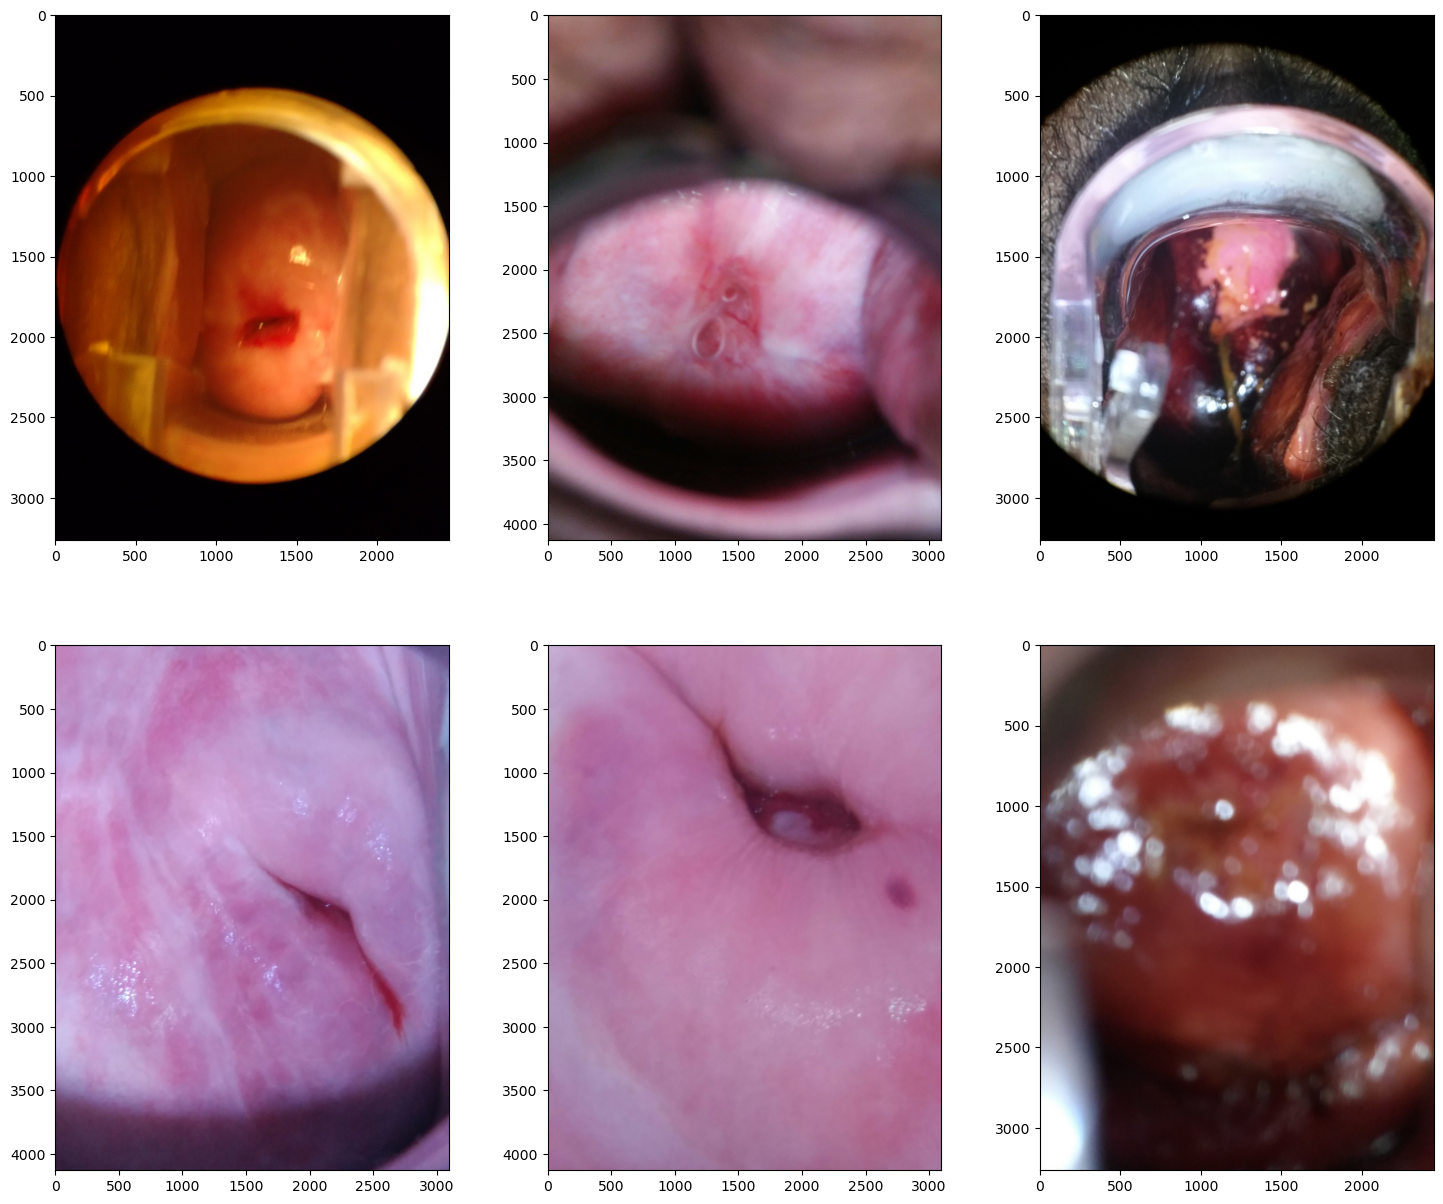

In [4]:
plt.figure(figsize=(18,15))
for i in range(len(df)):
    bgr_image = cv2.imread(os.path.join(df['train_dir'][i],df['random_sample'][i]))
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    
plt.show()

# Augmented Data Generator

In [5]:
data_augmentation = ImageDataGenerator()

# Custom augmentation function
def custom_augmentation(image):
    randomness = np.random.rand()
    if randomness < 0.25:
        # Apply rotation
        angle = np.random.randint(-90, 91)  # Random rotation angle between -90 and 90 degrees
        image = data_augmentation.apply_transform(image, {'theta': angle})
    elif 0.25 <= randomness < 0.5:
        # Apply brightness adjustment
        brightness_factor = np.random.uniform(0.5, 1.5)
        image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)
    elif 0.5 <= randomness < 0.75:
        # Apply crop by zoom
        zoom_factor = np.random.uniform(1.25, 1.75)
        image = data_augmentation.apply_transform(image, {'zx': zoom_factor, 'zy': zoom_factor})
    else:
        # Apply blur effect
        image = cv2.GaussianBlur(image, (5, 5), 0)

    return image

# Generate Dataset with Augmentation

In [6]:
data = []
labels = []
class_names = list(['Type 1','Type 2','Type 3'])
image_size = (227, 227)

l = -1
for path in train_dir:
    files = os.listdir(path)
    l = l + 1
    print(f'Reading files from {path}')
    for i in tqdm(files, desc=f'Processing {path}'):   
        bgr_image = cv2.imread(os.path.join(path, i))
        # Check if the image is successfully read (not empty)
        if bgr_image is not None:
            # Convert BGR image to RGB
            image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        else:
            image = bgr_image
        try:
            image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
        except:
            continue
        data.append(image)
        labels.append(l % 3)
        # Apply augmentation on 20% of the data
        if np.random.rand() < 0.2:  # 20% probability
            augmented_image = custom_augmentation(image)
            data.append(augmented_image)
            labels.append(l % 3)
        else:
            continue

# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

X = np.array(data)
y = np.array(labels)

# Delete the data and labels arrays to save memory
del data
del labels

Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_1


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_1:   0%|          | 0/250 …

Premature end of JPEG file


Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_2


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_2:   0%|          | 0/781 …

Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_3


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_3:   0%|          | 0/450 …

Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_1_v2/Type_1


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_1_v2/Type_1:   0%|         …

Premature end of JPEG file


Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_2_v2/Type_2


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_2_v2/Type_2:   0%|         …

Premature end of JPEG file


Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3:   0%|         …

Freeing up memory!


In [7]:
# Check for consistency in data and label shapes and file counts
print(f'Dataset Shape: {X.shape}, Labels Shape: {y.shape}')
t1 = np.count_nonzero(y==0)
print(f'Type 1 Samples: {t1}')
t2 = np.count_nonzero(y==1)
print(f'Type 2 Samples: {t2}')
t3 = np.count_nonzero(y==2)
print(f'Type 3 Samples: {t3}')

no_samples = t1 + t2 + t3
print(f'Total Number of Samples after Augmentation: {no_samples}')

Dataset Shape: (9855, 227, 227, 3), Labels Shape: (9855,)
Type 1 Samples: 1697
Type 2 Samples: 5232
Type 3 Samples: 2926
Total Number of Samples after Augmentation: 9855


# Random Samples from Augmented Dataset

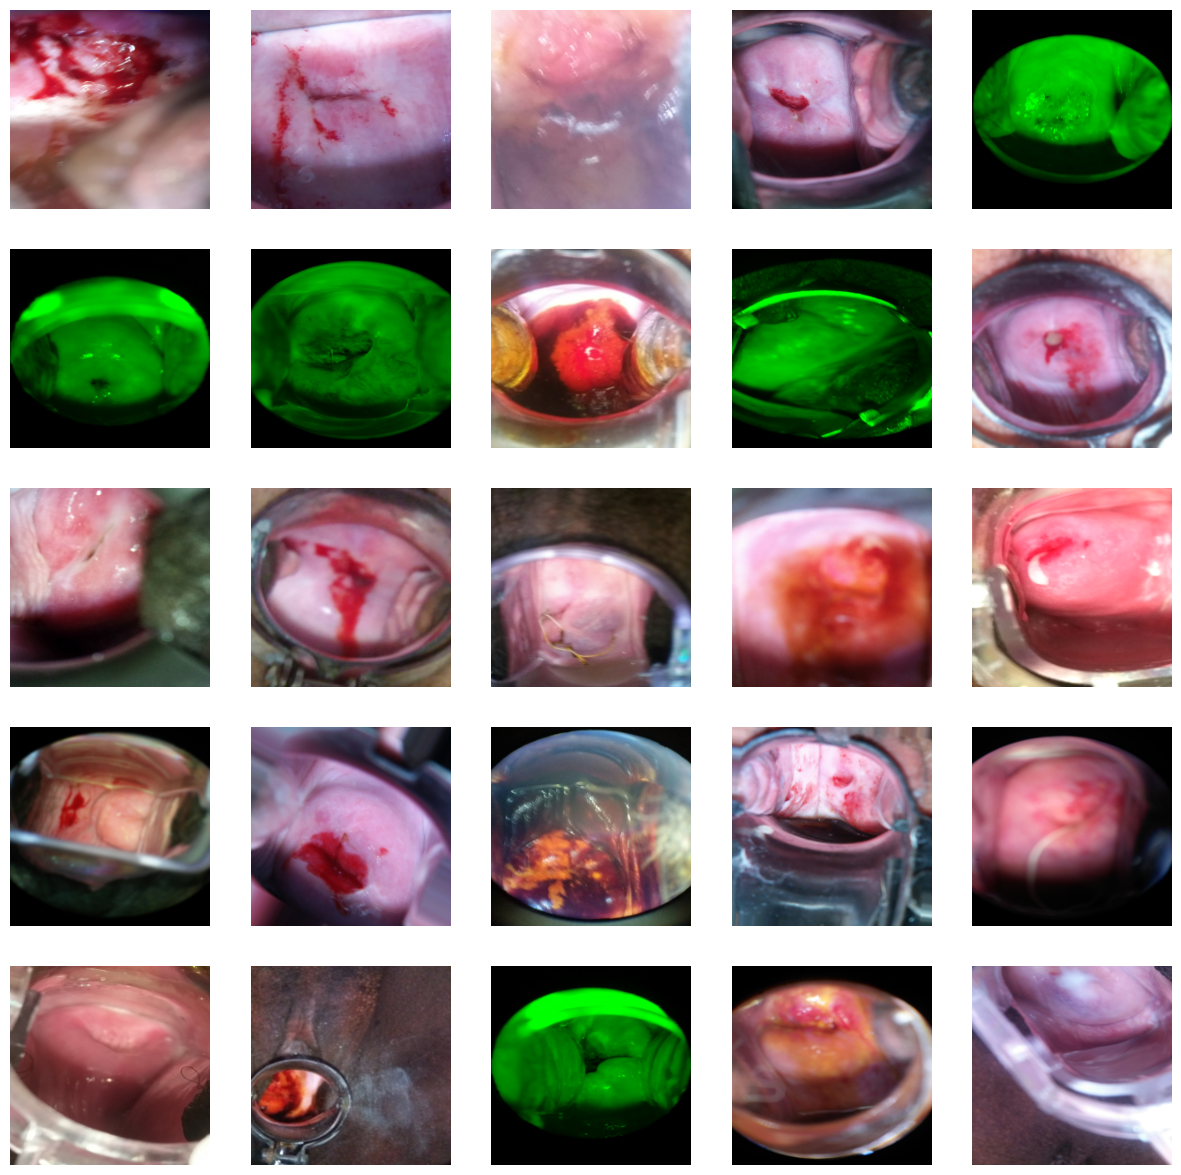

In [8]:
plt.figure(figsize=(15, 15))

for i in range(25):
    random_index = np.random.randint(0, X.shape[0])  # Generate a random index
    image = X[random_index]  # Extract the random image from the tensor
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis('off')  # Turn off axes

plt.show()

# Oversampling

In [9]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

X = X.astype(np.float16)

image_size = (227, 227)

# Calculate class distribution
class_distribution = Counter(y)
print("Class distribution before oversampling:", class_distribution)

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=2119)

# Reshape the data for oversampling
X_reshaped = X.reshape(-1, image_size[0] * image_size[1] * 3)

# Apply oversampling
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y)

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

# Reshape the data back to the original shape
X_resampled = X_resampled.reshape(-1, image_size[0], image_size[1], 3)

# Calculate class distribution after oversampling
resampled_class_distribution = Counter(y_resampled)
print("Class distribution after oversampling:", resampled_class_distribution)

Freeing up memory!
Class distribution before oversampling: Counter({1: 5232, 2: 2926, 0: 1697})
Shape of X_resampled: (15696, 154587)
Shape of y_resampled: (15696,)
Class distribution after oversampling: Counter({0: 5232, 1: 5232, 2: 5232})


# Train-Validation-Test Split

In [10]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=19)

# Perform train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=21)
# Change random_state value for a different split

print(f'Total Number of Samples after Oversampling: {len(y_resampled)}')
print(f'Samples in Train Set: {len(y_train)}')
print(f'Samples in Validation Set: {len(y_val)}')
print(f'Samples in Test Set: {len(y_test)}')

Freeing up memory!
Total Number of Samples after Oversampling: 15696
Samples in Train Set: 10044
Samples in Validation Set: 2512
Samples in Test Set: 3140


# Save Data Splits

In [11]:
splits = {
    'x_train': x_train,
    'x_val': x_val,
    'x_test': x_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

print("Saving data splits ...")
with open('data_splits_for_cyenet.pkl', 'wb') as f:
    pickle.dump(splits, f)
    
print("Data splits saved successfully.")

Saving data splits ...
Data splits saved successfully.
